In [1]:
#1
#importing necessary library and packages

import numpy as np  #for numerical calculations
import matplotlib.pyplot as plt  #for plotting graphs and visulaizing data
from matplotlib import colormaps  #for color maps which helps to colorize plots (heatmaps, spectrogrmas, etc.)
#%matplotlib inline



import gwpy  #GWpy is made to work with LIGO/VIRGO data
import framel  #for reading .gwf files

from gwpy.timeseries import TimeSeries  #it handles time-domain gravitational wave data
from gwpy.frequencyseries import FrequencySeries  #it handles frequency-domain gravitational wave data


In [2]:
#2
#Loading the necessary datas

aligo_asd = np.loadtxt("aligo_O4high.txt")  #Loads the text file "aligo_04high.txt" as aligo_asd, a numpy array
freq = aligo_asd[:, 0]  #Selects all row (:) from the column (0)
asd = aligo_asd[:, 1]  #Selects all row (:) from the second column (1), asd is the strength of the frequency

In [3]:
#3
#Filtering the frequency and amplitude spectral density

#The frequency range is limited to the range 10-2000 Hz
freq_range_low = 10  #Sets the lower limit of the frequency range to 10 Hz
freq_range_high = 2000  #Sets the upper limit of the frequency range to 2,000 Hz
freq_range_limits = np.where((freq>freq_range_low) & (freq<freq_range_high))  #Combines two conditions for filtering the frequency
freq_range = freq[freq_range_limits]  #stores the filtered frequency value
asd = asd[freq_range_limits]  #uses the same limit to store the ASD values


In [4]:
#4
#Function to generate simulated detector noise in the time domain based on frequency and strain sensitivity.


'''
n_points computes how many samples there will be in the time-domain noise
freq gives the frequencies from 0 to half the sampling frequency in steps of 1/duration.
noise_interp interoplates the strain values at the desired feq for accurate noise modeling
phase gives random phase, interpolate value at freq, based on known data points (f_range, strain_range)
np.exp(2j * np.pi * phase) assigns a random complex phase to each frequency component
It is then normalized to make the inverse FFT have the correct power
noise_ts converts the complex frequency-domain noise into a real-valued time series using 
inverse real FFT

Choose a frequency resolution and total duration,
At each frequency, a random amplitude scaled by the detector's sensitivity curve is assigned,
Each frequency bin gets a random phase,
Inverse FFT is done to get a realistic, time-varying noise signal
'''

def generate_noise(frequency_range, strain_range):
    
    '''
    Function to genertate the noise of length 't' [in seconds] for the 
    sampling frequency fs [in Hz] in the given frequency range and strain
    range
    '''
    
    n_points = fs*duration 
    #so that the time series hass the correct length, fs is the sampling frequency, duration is total time, and n_points is total number of points in the time-domain noise signal.
    freq = np.arange(0, fs*duration/2+1, dtype = float)/duration
    #Creates an array of equally spaced frequency values from 0Hz to Nyquist frquency
    #Interpolate sensitivity curve at equally spaced frequencies 
    noise_interp = np.interp(freq, frequency_range, strain_range)
    #generate random phases for signal reconstruction, one for each f bin
    phase = np.random.randn(np.shape(noise_interp)[0]) 
    #assigns random phase to each frequency values
    
    #Normalization
    noise_f = np.sqrt(duration/2.)*fs*noise_interp*np.exp(2j*np.pi*phase)
    #creating noise by using normalizetion factor, sampling frequency, noise sensitivity curve
    noise_ts = np.fft.irfft(noise_f)
    #creating noise in the time waveform, inverse Fourier transform
    
    return noise_ts



In [5]:
#5
#Lising the required parameters

duration = 600 # seconds #sets the total time for which the noise signal will be generated
fs = 4096  # Hz #how many data points are recorded per second
dt = 1.0/fs  #time interval between each sampled data points
t0 = 1234567890  #start time of the noise signal in this case February 18, 2019.
channel = "A1:hoft"  #channel name where the data is recorded
name = "A1:hoft"  #assigning name to the data
global duration,fs  #global keyword makes duration and fs available everywhere in the script

from gwpy.time import tconvert 

a = tconvert(t0)
print(a)

2019-02-18 23:31:12


In [6]:
#6
#stores the generated noise

'''
Calls the generate noise function to create a simulated time-domain
detector noise signal and stores it in the variable background_noise.
This function takes two inputs:- freq_range, which is an arrary of 
frequencies and asd, whihc is the amplitude spectral density (strain/sqrtHz)
of the detector noise at those frequencies. Inside the function, it
first determines how many times samples to generate based on the duration
and fs. It then calculates the frequency bins associated with the simulation
and uses linear interpolation to get the ASD values (noise_interp) at each
of these frequencies. Random phases are assigned to each frequency bin to 
ensure the noise is temporally random. These aplitude-scaled, pahse-randomized
frequency components are combined into a complex frequency-domain signal. Finally,
an inverse real FFT (irff) is applied to convert this signal into the 
time domain. The result is a realistic strain noise signal that mimics
the spectral behavior of a gravitational-wave detector, and its stored
in background_noise for further analysis or simulation use.'''
background_noise = generate_noise(freq_range, asd)

In [7]:
#7
#Creates a time series object for the simulated detector noise and 
#saves it to a file in .gwf format
#generated the file name by extracting the first 3 and everything 
#after the 3rd character.
#converts the start time and duration to a string

"""
Convert the noise array into well-defined time series object with channel metadata
Save that time series as a .gwf file"""
background_noise_series = TimeSeries(background_noise, dt = dt, t0 = t0, name = name, channel = channel)
background_noise_series.write(channel[:2]+'-'+channel[3:]+'-'+str(t0)+'-'+str(duration)+'.gwf')

In [8]:
#8
#Normalization of the walk from -1 to 1


'''
The function simulates a 1D random walk and normalized its values to
lie in the range [-1, 1]. It begins by generating a sequence of steps
where each step is randomly either -1 or +1, mimicking the classic
"left" or "right" movement at each time step. These steps are accumulated
using a cumulative sum to create the walk's position over time. However,
this raw walk can have values spanning a wide range, depending on how far
it drifted. To standardize the output, the walk is normalized:first,
it subracts the minimum value so that the walk starts at zero or above:
then it divides by the total range(max - min) to scale it into [0,1].
This results in finally mapped to [-1, 1] by multiplying by 2 and 
subracting 1. The result is a fluctuating 1D path that always stays
between -1 and 1 regardless of how many steps you take. This normalization
is useful to have consistent amplitude rand.

'''
def random_walk_1d(steps):
    walk = np.random.choice([-1,1], size = steps) 
    #Randomly selects -1 or 1 for each of the steps
    nwalk = np.cumsum(walk) 
    #computes the cumulative sum of the array walk
    random_walk = 2*(nwalk - np.min(nwalk))/(np.max(nwalk) - np.min(nwalk)) - 1
    #finds the lowest and highest position, shifts the entire walk so that the minimum value becomes 0,
    #scales between 0 and 1, then multiplies by 2 then subracts one.
    return random_walk #returns the normalized random walk


In [9]:
#9
#Generates a noisy sinusoidal signal with frequency and amplitude
#that vary over time. The variations are controlled by random walks,
#making the frequency and amplitude fluctuate smoothly.

'''

It generates a synthetic sine wave signal that mimics realistic line
noise, such as narrowband interference, in gravitational wave data.
The signal's frequency and amplitude fluctuate slowly over time,
controlled by a random walk. 

First, the function prints the timescale of variation, calculated by
divinding the total signal duration by the number of segments (nsplit).
It then creates a time array 't' with fs x duration points, representing
evenly spaced time samples. This array is reshaped into nsplit chunks
using t_split = t.reshape(nsplit, -1) so that each segment of the signal
can have its own frequency and amplitude variations.

To model frequency drift, it uses random_walk_1d(nsplit) to create a
smoothly varying normalized random walk with 'nsplit' values. This 
walk is scaled by the central_frequency and divided by freq_fuzziness
to produce fuzz_freq - an array of fluctuating freqeuncies for each 
segment. These frequency values are multiplied element-wise with the
corresponding time slices in 't_split', generating a new time base 
'newt' that encodes the local stretching or compression of time due
to frequency variation.

Similarly, to simulate amplitude modulation, a second random walk
is generated and scaled by the amplitude and amplitude_fuzziness,
producing fuzzy_amplitudes, which fluctuate around the base amplitude.
These are broadcasted across each time segment via an array of ones
'a_split', reshaped and flattened back into 'fuzzy_amplitude'.

Finaly, the signal 'line_noise' is computed as a sine wave.

This sine wave has time-varying frequency and time-varying amplitude,
achieved by the earlier construction of 'newt' and 'fuzzy_amplitude'.
The result is a simulation of line noise like what might appear in
a real detector.
'''

def generate_line(amplitude, phase, central_frequency, nsplit, freq_fuzziness, amplitude_fuzziness):
    print('The timescale of the variation is %f seconds' %(duration/nsplit))
    t = np.linspace(0, duration, fs*duration) 
    #creates a time array t that spans from 0 to duration with fs*duration points
    t_split = t.reshape(nsplit, -1) 
    #Reshapes the time array into nsplit segments
    random_walk_freq = random_walk_1d(nsplit)
    fuzzy_freq = central_frequency * (1 + random_walk_freq/freq_fuzziness)
    #Generate small fluctuations in frequency
    print('The frequency range of the variation is [%f, %f] Hz' %(np.min(fuzzy_freq), np.max(fuzzy_freq)))
    newt = (t_split * fuzzy_freq[:, None]). flatten() 
    #multplies each time segment by its corresponding fuzzy_freq value
    random_walk_amplitude = random_walk_1d(nsplit)
    fuzzy_amplitudes = amplitude * (1 + random_walk_amplitude/amplitude_fuzziness)
    print('The amplitude range of the variation is [%e, %e] Hz' %(np.min(fuzzy_amplitudes), np.max(fuzzy_amplitudes)))
    a_split = np.ones(fs*duration).reshape(nsplit, -1) 
    #creates an array of ones matching the time array size
    fuzzy_amplitude = (a_split * fuzzy_amplitudes[:, None]).flatten() 
    #reshapes it into nsplit segement and each segment gets multiplied by its corresponding fuzzy_amplitudes values, .flatten() converts it back into a 1D array.
    line_noise = np.multiply(fuzzy_amplitude, np.sin(2 * np.pi * newt + phase)) 
    #generates a sine wave with fluctuating frequency and amplitude, produces the oscillations and sclaes the oscillations with varying amplitdue.
    return line_noise

In [10]:
#10
#Generate a noisy sinusoidal signal with a fluctuating frequency
#and amplitude using random walks, simulating realistic time-varying
#waveforms.

'''
It generates a time-varying sinusoidal signal 'line_noise', designed
to simulate narrowband instrumental noise (like a spectral line)
with subtle, continous fluctuations in both frequency and amplitude,
similar to what gravitational wave detectors might observe in real
data. The function 'generrate_line' is called with six parameters.
The first, 10**(-22), sets the base amplitude of the signal, matching
the tiny strain sensitivity of LIGO/Virgo detectors. The second,
np.pi/4, introduces a phase offset of 45 degree, shifting the sine
wave horizontally. The third, 128, sets the central frequency in Hz,
placing the signal near a common line frequency (e.g. 60 Hz harmonics
or calibration lines). The fourth, 4096, determines how many segements
the full time series is divided into, allowing for smooth, gradual
changes in the waveform properties every ~0.15 seconds (duration is
600s). The fifth parameter, 4, is the frequency fuzziness factor, 
controlling how much the frequency can randomly drift across segments
(higher value = smaller drift), and the sixth, 2, is the amplitude 
fuzzinees factor, which governs the variation range around the base 
amplitude. Internally, these modulations fluctuate realistically but 
remain bounded. The resulting output, 'line_noise', is a synthetic
signal that mimics detector line artifacts, useful for injecting into
noise or testing signal recovery pipelines.
'''

line_noise = generate_line(10**(-22), np.pi/4, 128, 4096, 4, 2)

The timescale of the variation is 0.146484 seconds
The frequency range of the variation is [96.000000, 160.000000] Hz
The amplitude range of the variation is [5.000000e-23, 1.500000e-22] Hz


In [11]:
#11
#adds line noise to background noise

background_noise_with_line = background_noise + line_noise

In [12]:
#12
#Saves the generated noisy signal as a Gravitational Wave Frame file

background_noise_with_line_series = TimeSeries(background_noise_with_line, dt = dt, t0 = t0, name = name+'_line', channel = name+'_line')
background_noise_with_line_series.write(channel[:2]+'-'+channel[3:]+'_line-'+str(t0)+'-'+str(duration)+'.gwf')

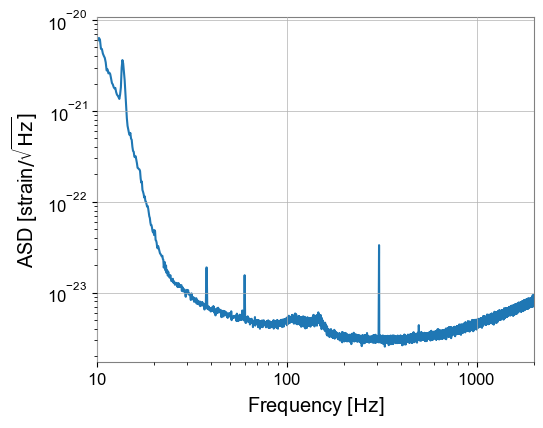

In [13]:
#13
#Computes the ASD using a Fast Fourier transform (FFT) with 8-second segment duration and 4-second overlap between segments.
#Plots the ASD, showing how the signal's power is distributed across frequencies.
#Restricts the frequency range to [freq_range_low, freq_range_high]
#Uses LaTeX formattig to label the ASD in strain per square root Hertz

'''
It calculates and plots the Amplitude Spectral Density (ASD) of a 
time-series signal that contains both simulated background noise 
and a synthetic line signal. The purpose is to visualize how the 
signal's power is distributed across different frequencies, especially
in the presence of the line feature. 'background_noise_with_line_series_asd'
computes the ASD using a Fast Fourier Transform (FFT) method, 
breaking the signal into overlapping segments of 8 seconds each with
a 4-second overlap. This segmentation improves statistical 
reliability by averageing multiple FFTs and helps resolve narrow
frequency features like line noise. The result is stored in 
'background_noise_with_line_series_asd', which is then plotted.
The plotting object ax_asd is used to access and modify the curren
plot's axes. The frequency range of the x-axis is restricted using
'ax_asd.set_xlim(freq_range_low, freq_range_high)' to focus only
on frequencies of interest (eg. where the line is expected). Finally,
the y-axis is labeled, using LaTeX-style formatting to indicate the
unit of ASD: strain per square root Hertz.
'''

background_noise_with_line_series_asd = background_noise_with_line_series.asd(8, 4)
plot_background_noise_with_line_series_asd = background_noise_with_line_series_asd.plot()
ax_asd = plot_background_noise_with_line_series_asd.gca()
ax_asd.set_xlim(freq_range_low, freq_range_high)
ax_asd.set_ylabel(r'ASD [strain$/\sqrt{\mathrm{Hz}}$]')
import warnings
warnings.filterwarnings("ignore", message="FigureCanvasAgg is non-interactive, and thus cannot be shown")

plot_background_noise_with_line_series_asd.show()



In [14]:
#14
#computes the spectrogram of background_noise_series, which represents
#how the frequency content of the signal changes over time

'''
It computes the spectrogram of a time-series signal and converts it
from power to amplitude units by taking the square root. It breaks
the entire signal into 8-second segments, within which it performs
a Fast Fourier Transform (FFT) using 4-second windows that overlap
by 2 seconds. This process creates a spectrogram which is a time-
frequency representation showing how the signal's frequency content
evolves over time. Since the raw spectrogram yields power, the 
expression ** (1/2.) takes the square root to obtain amplitude, which
is more intuitive and consistent with strain units in gravitational-
wave analysis. The resulting spectrogram provides insight into how
the noise amplitude varies over time and frequency, making it easier
to detect transient features or frequency-dependent pattersn in the
background signal.
'''
spectrogram_no_line = background_noise_series.spectrogram(8, fftlength = 4, overlap = 2) ** (1/2.)

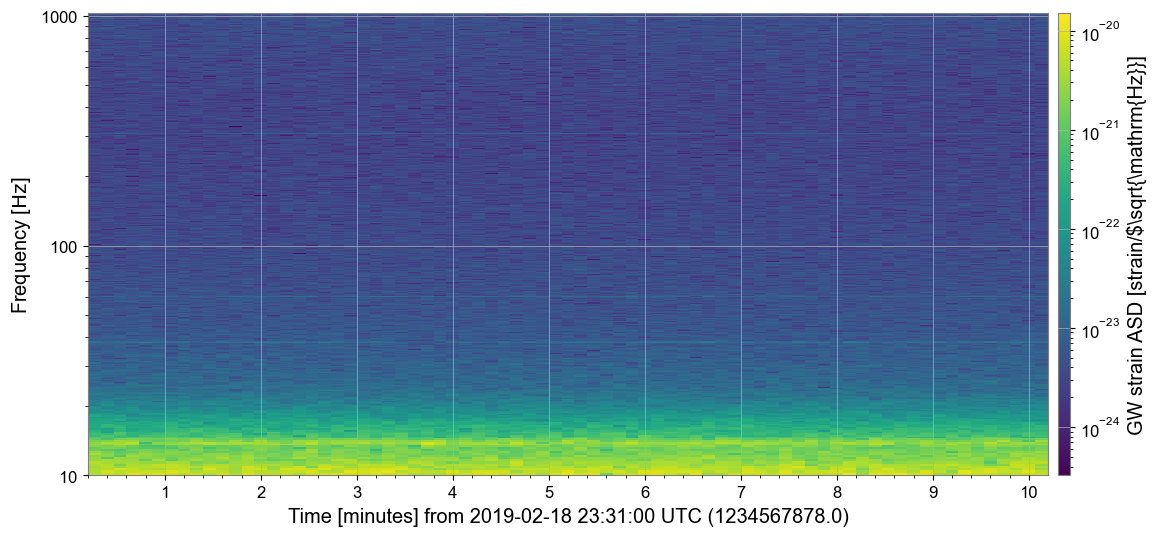

In [15]:
#15
#Plots the spectrogram of the background noise in a logarithmic scale
#allowing visulization of frequency variation over time in gravitational
#wave strain data.
#Generates a heatmap of the spectrogram, uses a logarithmic color 
#scale which helps visualize both weak and strong signals.
#Retrieves the current axis from the plot for further customization
#Limits the frequency range to freq_range_low and 1024 Hz
#Uses a logarithmic frequency scale for better visibility of both
#low and high frequency components
#Adds a colorbar showing the Amplitude Spectral Density in strain
#per the standard gravitational wave unit.

'''
The code visualizes the spectrogram of a gravitational-wave background
noise signal, displaying how its frequency content varies over time.
The first lne, 'spectrogram_no_line.plot(norm = 'log')', creates a 
plot of the spectrogram using a logarithmic color scale (norm = 'log')
to better highlight features across several orders of magnitude in
amplitude. The line 'ax_spectrogram_no_line' retrieves the current
axes of the plot so we can further customize it. Then, the y-axis
is limited to show only the frequency range of interest-from a 
predefined low frequency ('freq_range_low') to 1024 Hz. 'log' changes
the frequency axis itself to a logarithmic scale, which is common
in GW phsyics to empahsize features across low and high frequencies. 
Colorbar is added to the side of the plot, labeled to indicate that
the color represents the ASD in strain per square root Hertz.
'''

spectrogram_no_line_plot = spectrogram_no_line.plot(norm = 'log')#, vmin = 1e-23, vmax = 1e-19
ax_spectrogram_no_line = spectrogram_no_line_plot.gca()
ax_spectrogram_no_line.set_ylim(freq_range_low, 1024)
ax_spectrogram_no_line.set_yscale('log')
ax_spectrogram_no_line.colorbar(label = 'GW strain ASD [strain/$\sqrt{\mathrm{Hz}}]')
spectrogram_no_line_plot.show()

In [16]:
#18
#Defines a range around the midpoint of a given time window (t0 and duration)
#sets the width of the scan range
#start of the scan range
#end of the scan range

'''
This code defines a specific time range centered in the middle of
a gw signal to be used for a Q-transfrom scan, often called a Q-scan,
which is useful for identifying transient signals or glitches in the
data. First, 'qscan_width = 16' sets the total width of the time
window to 16 seconds. The next two lines calculate the start and end
times of this window. 'qscan_range_low' computes the lower bound of
the Q-scan time range by taking the midpoint of the entire signal
and subtraccting 16 seconds to go back in time. Similarly, 
'qscan_range_high' calculates the upper bound by adding 16 seconds
to the midpoint, thus defining a 32-second window centered around
the middle of the data. This window is commonly used to inspect the
most statistically stable part of the signal or to focus on a 
particular region for detailed spectral analysis.
'''

qscan_width = 16
qscan_range_low = t0 + duration / 2 - qscan_width
qscan_range_high = t0 + duration / 2 + qscan_width

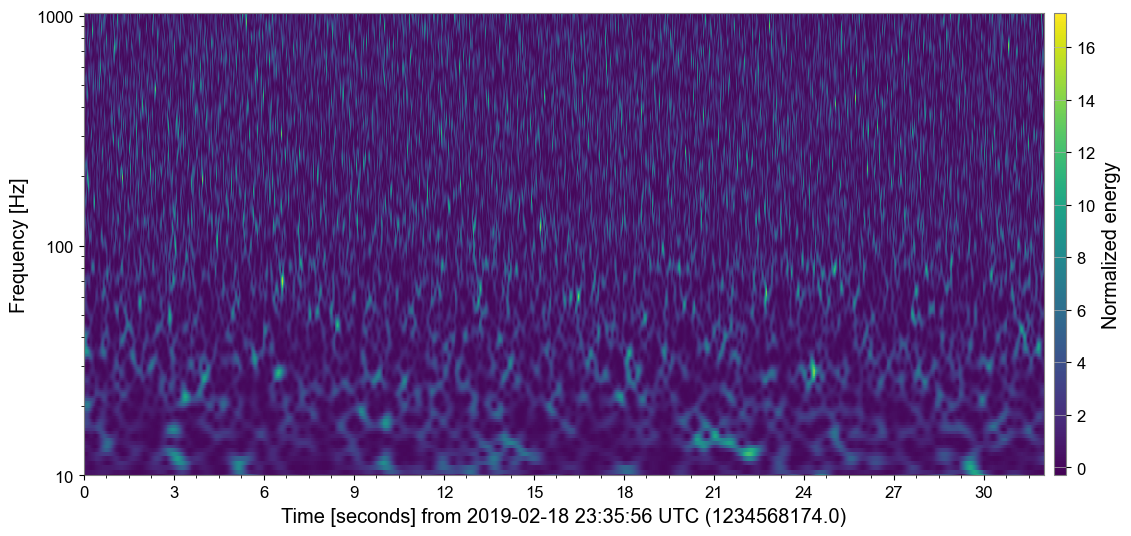

In [17]:
#19
#performs a quick scan on the background_noise_series within a 
#specified time window and plots the results using a logarithmic
#frequency scale.
#Plot the quick scan results
#Access the axis object for customization
#remove grid and set logarithmic y-axis scale
#set frequency limits on y-axis 
#label the y-axis

'''
This code first whitens the gravitational wave time series data to 
flatten the noise spectrum, making signals easier to detect. It then
applies a Q-transfrom over a specified time segment, which provides 
a detailed time-frequency analysis useful for identifying transient
events. The resulting Q-transform data is plotted, and the plot's 
axes are customized: grid lines are turned off for clarity, the 
frequency (y-axis) is set to a logarithmic scale to better display 
a wide frequency range, and the frequency limit are set between a
predefined lower bound and 1024 Hz to focus on relevant frequencies.
'''

qscan_no_line = background_noise_series.whiten().q_transform(outseg = (qscan_range_low, qscan_range_high))
qscan_no_line_plot = qscan_no_line.plot()
ax_no_line = qscan_no_line_plot.gca()
ax_no_line.grid(False)
ax_no_line.set_yscale('log')
ax_no_line.set_ylim(freq_range_low, 1024)
ax_no_line.set_ylabel('Frequency [Hz]')
qscan_no_line_plot.colorbar(label = 'Normalized energy')

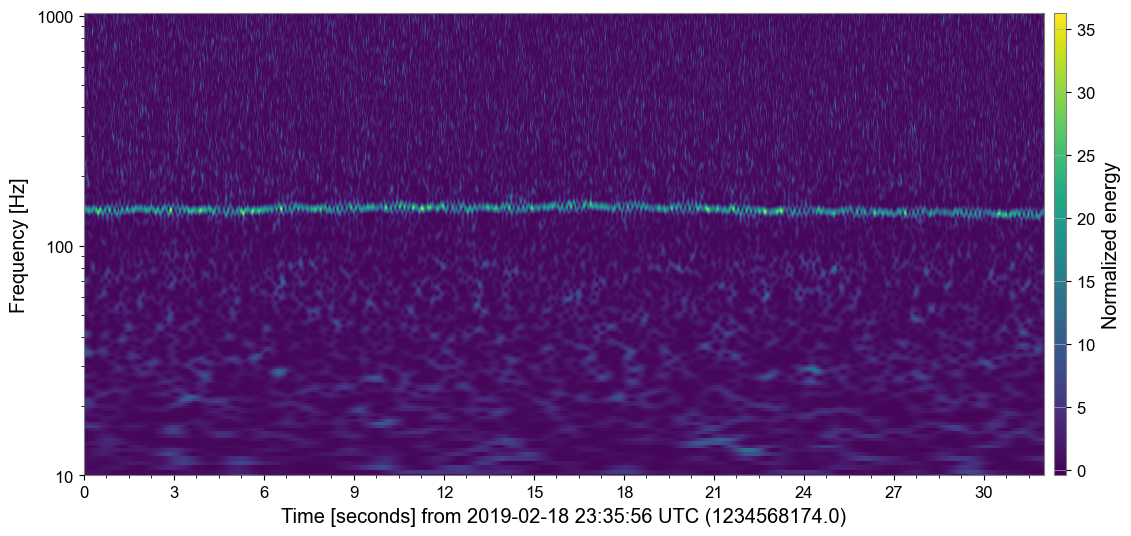

In [18]:
#20
#Applies quick scan (Q-transform) to the signal that inclues both
#background noise and line noise
#Apply whitening and perform Q-transform
#Plot the quick scan results
#.gca() retries the current axis of the plot for further customization
#removes grid and set logarithmic y-axis scale
#set frequency limits on y-axis

qscan_with_line = background_noise_with_line_series.whiten().q_transform(outseg = (qscan_range_low, qscan_range_high))
qscan_with_line_plot = qscan_with_line.plot()
ax_with_line = qscan_with_line_plot.gca()
ax_with_line.grid(False)
ax_with_line.set_yscale('log')
ax_with_line.set_ylim(freq_range_low, 1024)
ax_with_line.set_ylabel('Frequency [Hz]')
qscan_with_line_plot.colorbar(label = 'Normalized energy')